In [15]:
%matplotlib inline

In [16]:
import glob
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


sys.path.append('/2tb_drive/old_data/notebooks/Anna/EEM_device/skin_reflectometer/')

import savers
import lab_tools.plot_utils as pu
pu.load_figure_style()



sys.path.append('/2tb_drive/old_data/notebooks/Anna/')
import dataframe_preprocessing as dfprep

import datetime

# import eem_preprocessing_stones as eem_prep

import pickle as pkl
import pathlib
import sklearn

In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
folder = '/4tb_drive/ipython/data/surgical_fluorimeter/urology/stones/stone_type_density/eem_kno/'
date = '21_03_2024/'
path = pathlib.Path(folder+date)

In [5]:
folder+date

'/4tb_drive/ipython/data/surgical_fluorimeter/urology/stones/stone_type_density/eem_kno/21_03_2024/'

In [6]:
def load_spectra_data(path, mask='*.hdf'):
    return sorted(path.glob(mask))

In [7]:
files = load_spectra_data(path, mask='*.hdf')

In [8]:
files[-1]

PosixPath('/4tb_drive/ipython/data/surgical_fluorimeter/urology/stones/stone_type_density/eem_kno/21_03_2024/19_43_44_604754_059_.hdf')

In [9]:
test = files[-1]

In [10]:
eem = {}
comments = []
for file in files: 
    comment = file.stem[16:-1]
    comments.append(comment)
    with pd.HDFStore(file, mode='r') as f:
        metadata = f.get('metadata')
        data = f.get('values')
        wvs = f.get('wavelengths').iloc[0]
        
    sers = []
    for num in data.T:
        spec = data.T[num].values
        ser_spec = pd.Series(data=spec, index=wvs)
        sers.append(ser_spec)
    metadata['spectra'] = sers
    exc_column = 'monochromator_settings__wavelength'
    for name, group in metadata.groupby(exc_column):
        spec = group['spectra'].apply(lambda x: x).mean()
        smoothed_spec = spec.rolling(20, center = True).mean(engine='numba') 
        
        if name in eem:
        # append the new number to the existing array at this slot
            eem[name].append(smoothed_spec)
        else:
        # create a new array in this slot
            eem[name] = [smoothed_spec]


In [11]:
df = pd.DataFrame(eem)
df['stone'] = comments

In [12]:
df.stone.unique()

array(['093', '067', '106', '084', '100', '095', '063', '064', '071',
       '069', '065', '074', '066', '072', '057', '015', '058', '053',
       '088', '046', '013', '037', '070', '059'], dtype=object)

In [13]:
def norm(ser):
    return (ser - ser.min()) / (ser.max() - ser.min())

320.0
340.0
360.0
380.0
400.0
420.0


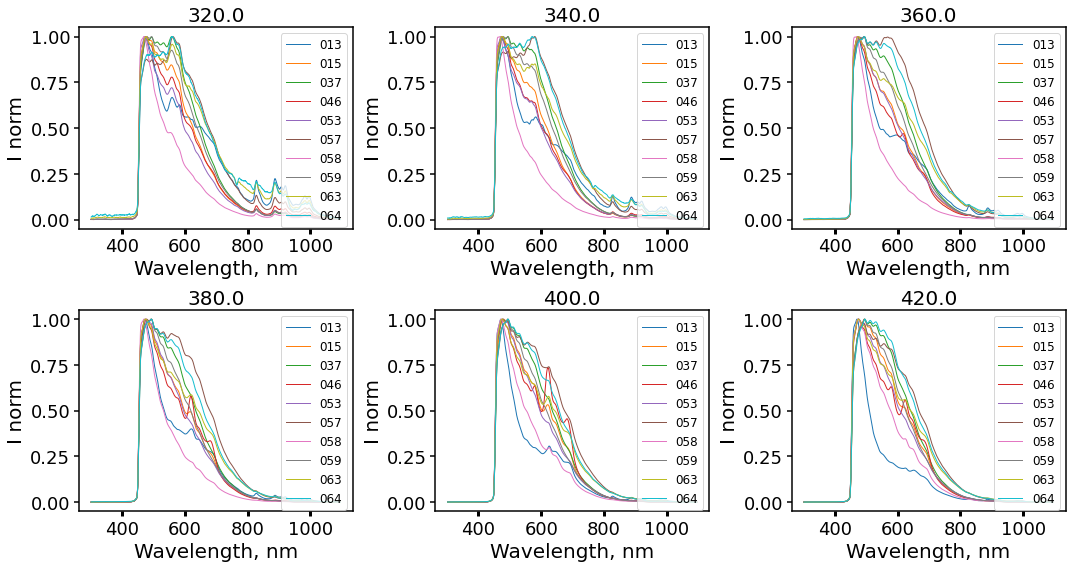

In [14]:
import matplotlib.lines as mlines
num = len(df.columns[:-1]) // 3
fig, axs = plt.subplots(num, 3, figsize=(15, num*4))

kwargs = {
    'lw': 1,
}

kwargs_grey = {
    'lw': 1,
    'alpha': 0.4,
    'color': 'grey'
}

for exc, ax in zip(df.columns[:-1], axs.flatten()):
    lines = []
    for i, (name, group) in enumerate(df.groupby('stone')):
    
        normed_proc_eem = group[exc].apply(norm).T
        normed_proc_eem.apply(ax.plot, color=f'C{i}', label = f'{name}', **kwargs)
        line = mlines.Line2D([], [], color=f'C{i}', label=name, **kwargs)
        lines.append(line)
        if i == 9:
            break
    ax.legend(handles=lines, loc='upper right',  fontsize=12)
    ax.set_title(exc)
    ax.set_xlabel('Wavelength, nm')
    ax.set_ylabel('I norm')
    print(exc)
    
plt.tight_layout()

In [18]:
import pickle
path = './pickles/'
with open(path+'21_03_2024', 'wb') as f:
    pickle.dump(df, f)

In [19]:
df.stone.unique()

array(['093', '067', '106', '084', '100', '095', '063', '064', '071',
       '069', '065', '074', '066', '072', '057', '015', '058', '053',
       '088', '046', '013', '037', '070', '059'], dtype=object)